# TENSORBOARD로 모델, 데이터, 학습 시각화하기

- TensorBoard는 신경망 학습 내역을 시각화하는 도구이며, Pytorch와 통합되었다.
- 여기서는 `torchvision.datasets`의 [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist)을 통해 다음의 과정을 진행하며 몇가지 기능들을 살펴본다.
> 1. 데이터를 읽고 적절히 변환, 모델 학습
> 2. TensorBoard를 설정(set up)
> 3. TensorBoard에 기록(write)
> 4. TensorBoard를 사용해 모델 구조를 확인
> 5. TensorBoard를 사용해 고차원 데이터의 저차원 표현(representation)을 시각화
> 6. TensorBoard로 모델 학습 추적하기
> 7. TensorBoard로 학습된 모델 평가하기

## 1. 분류기 학습

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    train=True,
    transform=transform
)
testset = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    train=False,
    transform=transform
)

trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = (
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'
)


# 이미지 보여주는 함수 (helper function)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [4]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## 2. TensorBoard 설정

- `torch.utils.tensorboard`에서 TensorBoard에 정보를 제공(write)하는 `SummaryWriter`를 정의하여 TensorBoard를 설정

In [5]:
from torch.utils.tensorboard import SummaryWriter

# ./runs/fashion_mnist_experiments_1 디렉토리 생성
writer = SummaryWriter("./runs/fashion_mnist_experiment_1")

## 3. TensorBoard에 기록

- TensorBoard에 이미지를 기록

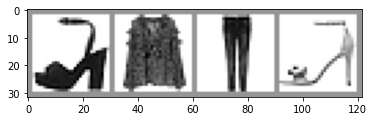

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# image를 grid 형태로 만들기
img_grid = torchvision.utils.make_grid(images)

# image_grid 확인
matplotlib_imshow(img_grid, one_channel=True)

# tensorboard에 기록
writer.add_image("four_fashion_mnist_images", img_grid)

아래 명령어 실행 후, http://localhost:6006 의 IMAGES 탭에서 기록한 이미지 확인 가능
> $ tensorboard --logdir=runs

## 4. TensorBoard를 사용해 모델 확인

- TensorBoard를 통해 모델의 구조를 시각화할 수 있음

In [7]:
writer.add_graph(model, images)
writer.close()

아래 명령어 실행 후, http://localhost:6006 의 GRAPHS 탭에서 모델 구조 확인 가능
> $ tensorboard --logdir=runs

## 5. TensorBoard를 사용해 고차원 데이터의 저차원 표현(representation)을 시각화

- `add_embedding()`를 통해 고차원 데이터의 저차원 표현(representation)을 시각화할 수 있음

In [8]:
def select_n_random(data, labels, n=100):
    '''
    Dataset에서 n개의 data instance와 label을 선택
    '''
    assert len(data) == len(labels)
    
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]


images, labels = select_n_random(trainset.data, trainset.targets)
class_labels = [classes[label_idx] for label_idx in labels]

features = images.view(-1, 28 * 28)
writer.add_embedding(features, metadata=class_labels, label_img=images.unsqueeze(1))
writer.close()

아래 명령어 실행 후, http://localhost:6006 의 PROJECTOR 탭에서 저차원 공간으로 projection된 결과를 확인 가능
> $ tensorboard --logdir=runs

## 6. TensorBoard로 모델 학습 추적하기

- TensorBoard를 사용해 학습 중 loss를 기록
- TensorBoard를 사용해 모델의 예측 결과 확인

In [9]:
def images_to_probs(model, images):
    '''
    학습된 모델과 image로부터 prediction 및 accuracy를 계산
    '''
    out = model(images)
    
    _, preds_tensor = torch.max(out, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[idx].item() for idx, el in zip(preds, out)]


def plot_classes_preds(model, images, labels):
    '''
    학습된 모델과 image/label을 사용해 matplotlib Figure 생성
    이때, 예측 결과 및 확률을 함께 보여주며 정답 여부에 따라 색깔을 다르게 표현
    '''
    preds, probs = images_to_probs(model, images)
    
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title(
            (f"{classes[preds[idx]]}, {probs[idx] * 100.0:.1f}%\n" +
             f"(label: {classes[labels[idx]]})"),
            color=("green" if preds[idx]==labels[idx].item() else "red")
        )
    
    return fig

In [10]:
running_loss = 0.0
for epoch in range(1):
    for i, data in enumerate(trainloader):
        inputs, labels = data
        
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        # 1000 iteration마다 기록
        if i % 1000 == 999:
            writer.add_scalar("training_loss",
                              running_loss / 1000,
                              epoch * len(trainloader) + i)
            
            writer.add_figure("prediction vs. actuals",
                              plot_classes_preds(model, inputs, labels),
                              global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print("Finish Training")

Finish Training


아래 명령어 실행 후, http://localhost:6006 의 SCALARS 탭에서 loss의 그래프를 확인 가능  
또한, IMAGES 탭에서 각 batch에 대한 model의 예측 결과를 확인 가능
> $ tensorboard --logdir=runs

## 7. TensorBoard로 학습된 모델 평가하기

- TensorBoard를 사용해 precision-recall 곡선 그리기

In [11]:
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    0부터 9까지의 class_index를 가져온 후, precision-recall curve를 기록
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

In [12]:
class_probs = []
class_preds = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        out = model(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in out]
        _, class_preds_batch = torch.max(out, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# 모든 precision-recall curve를 기록
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

아래 명령어 실행 후, http://localhost:6006 의 PR CURVES 탭에서 precision-recall curve를 확인 가능
> $ tensorboard --logdir=runs